***Import all the libraries***

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


***Add the dataset and convert the date format to integer type.***

In [2]:
df = pd.read_csv('../data/cases_train_processed.csv')

# Some preprocessing
df["date_confirmation"] = pd.to_datetime(df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) # convert date from object type to int type
df2 = df.copy() # creating a copy for lightgbm because of different processing method
df.head(5)

,age,sex,province,country,latitude_x,longitude_x,date_confirmation,additional_information,source,outcome,key,latitude_y,longitude_y,confirmed_sum,death_sum,recovered_sum,incidence_rate_avg,active_sum,Case-Fatality_Ratio
0,44.0,Unknown,Delhi,India,28.614740,77.209100,20200526,0,1,recovered,"Delhi, India",28.646519,77.108980,238828.0,4907.0,201671.0,1276.409575,32250.0,2.054617
1,44.0,Unknown,Uttar Pradesh,India,25.436090,81.847180,20200520,0,1,hospitalized,"Uttar Pradesh, India",26.925425,80.560982,342788.0,4869.0,270094.0,144.099577,67825.0,1.420411
2,44.0,Unknown,Maharashtra,India,18.504220,73.853020,20200526,0,1,hospitalized,"Maharashtra, India",19.449759,76.108221,1167496.0,31791.0,834432.0,948.072083,301273.0,2.723007
3,24.0,female,Baden-Wurttemberg,Germany,48.120860,7.849500,20200315,0,0,nonhospitalized,"Baden-Wurttemberg, Germany",48.661600,9.350100,46779.0,1871.0,41228.0,422.592353,3680.0,3.999658
4,44.0,Unknown,Gujarat,India,23.188409,73.647122,20200520,0,1,hospitalized,"Gujarat, India",22.694884,71.590923,120336.0,3286.0,100974.0,188.400627,16076.0,2.730687


# 1. K-Nearest Neighbours Classifier
### 1.1 Building the model
*Step 1: Convert all the categorical features into numerical by using Label encoding.*

In [3]:
df.dtypes

age                       float64
sex                        object
province                   object
country                    object
latitude_x                float64
longitude_x               float64
date_confirmation           int64
additional_information      int64
source                      int64
outcome                    object
key                        object
latitude_y                float64
longitude_y               float64
confirmed_sum             float64
death_sum                 float64
recovered_sum             float64
incidence_rate_avg        float64
active_sum                float64
Case-Fatality_Ratio       float64
dtype: object

In [4]:
#use label encoder to normalize categorical features in dataframe
le = LabelEncoder()
categoricalFeatures = ['sex', 'province', 'country','key','additional_information', 'source']
for feat in categoricalFeatures:
    df[feat]= le.fit_transform(df[feat])

*Split the dataframe into the training data and validation data after separating the outcomes column from the rest of the dataset.*

In [5]:
y = df['outcome']
X = df.drop(['outcome'], axis=1)

#split data into training and validation sets
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.20, random_state=11)

*Create and fit the K-Nearest Neighbours Classifier and save it as a pickle file.*

In [6]:
knn = KNeighborsClassifier(n_neighbors = 9, weights = 'distance')
knn.fit(training_data, training_truth)
# save the trained model to disk
pickle.dump(knn, open('../models/knn_classifier.pkl', 'wb'))

*Then, load the model from the pickle file and find the predictions on the training and validation data from the model.*

In [7]:
# load the model from disk
knn = pickle.load(open('../models/knn_classifier.pkl', 'rb'))
# predict on the training data
training_prediction = knn.predict(training_data)
#predict on the validation data
validation_prediction = knn.predict(validation_data)

### 1.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [8]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("K-Nearest Neighbours Model Predictions:\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

K-Nearest Neighbours Model Predictions:

TRAINING
Accuracy score: 0.88185
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.88      0.33      0.48      3586
   hospitalized       0.81      0.87      0.84    100092
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.79      0.73      0.76     70494

       accuracy                           0.88    294100
      macro avg       0.87      0.73      0.77    294100
   weighted avg       0.88      0.88      0.88    294100


VALIDATION
Accuracy score: 0.86416
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.47      0.11      0.18       913
   hospitalized       0.79      0.86      0.82     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.76      0.69      0.72     17643

       accuracy                           0.86     73526
      macro avg       0.75      0.66 

*Confusion matrix to provide a better insight to the predictions made by the KNN classifier.*

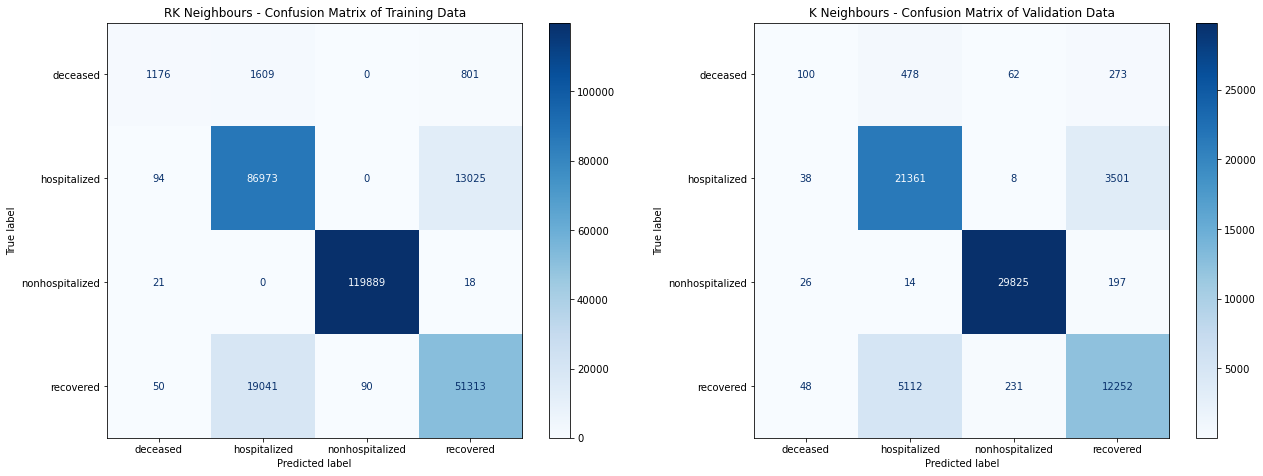

In [13]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(knn, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('RK Neighbours - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(knn, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('K Neighbours - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/knn_cm.png', bbox_inches='tight', pad_inches=0.3)

### 1.3 Detecting Overfitting
*Plotting the Accuracy measure on a range of the "n_neighbours" parameter to detect if the classifier is overfitting.*

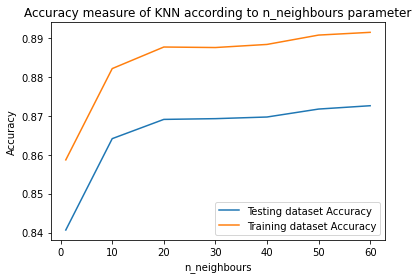

In [10]:
neighbors = [1,10,20,30,40,50,60]
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance') 
    knn.fit(training_data, training_truth) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(training_data, training_truth) 
    test_accuracy[i] = knn.score(validation_data, validation_truth) 
  
# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.title('Accuracy measure of KNN according to n_neighbours parameter')
  
plt.legend() 
plt.xlabel('n_neighbours') 
plt.ylabel('Accuracy') 
plt.savefig('../plots/knn_accuracy_curve.png')

plt.show()



# 2. Random Forests Classifier
### 2.1 Building the model
*Using the same training and validation dataset split from KNN, the Random Forests classifier is built and saved as a pickle.*

In [10]:
RF_clf = RandomForestClassifier(max_depth = 22)
RF_clf.fit(training_data, training_truth)
# save the trained model to disk
pickle.dump(RF_clf, open('../models/rf_classifier.pkl', 'wb'))

In [11]:
# load the model from disk
RF_clf = pickle.load(open('../models/rf_classifier.pkl', 'rb'))

# prediction on validation and training set
RF_validation_prediction = RF_clf.predict(validation_data)
RF_training_prediction = RF_clf.predict(training_data)


### 2.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [12]:
training_accuracy = metrics.accuracy_score(RF_training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,RF_training_prediction)
validation_accuracy = metrics.accuracy_score(RF_validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,RF_validation_prediction)
print("Random Forests Model Predictions:\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

Random Forests Model Predictions:

TRAINING
Accuracy score: 0.87781
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.98      0.24      0.39      3586
   hospitalized       0.80      0.88      0.84    100092
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.79      0.71      0.75     70494

       accuracy                           0.88    294100
      macro avg       0.89      0.71      0.74    294100
   weighted avg       0.88      0.88      0.87    294100


VALIDATION
Accuracy score: 0.86567
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.70      0.11      0.19       913
   hospitalized       0.79      0.87      0.83     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.77      0.68      0.72     17643

       accuracy                           0.87     73526
      macro avg       0.81      0.66      0

*Confusion matrix to provide a better insight to the predictions made by the Random Forests classifier.*

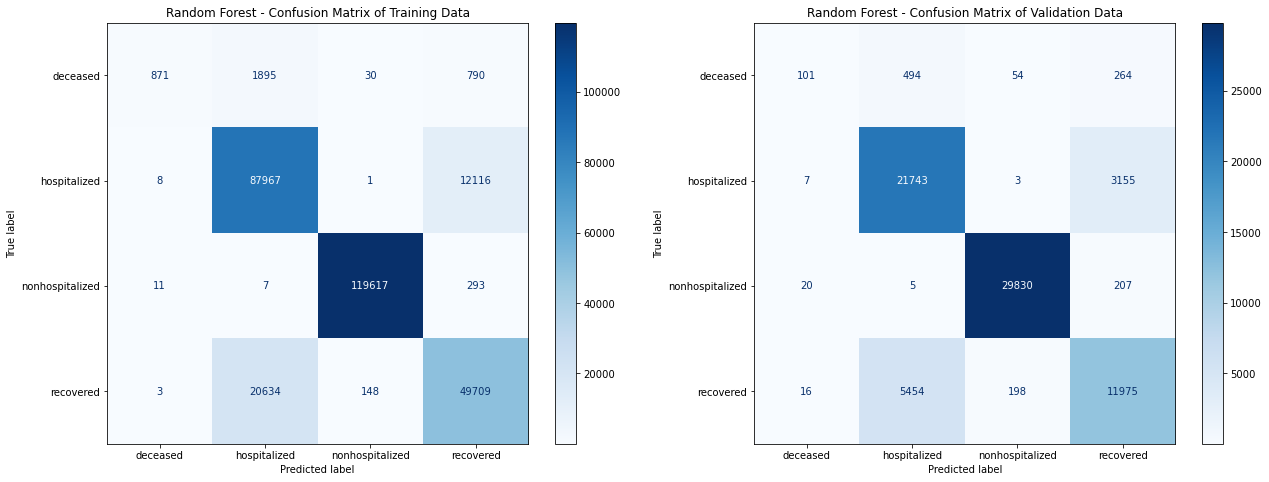

In [14]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(RF_clf, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('Random Forest - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(RF_clf, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('Random Forest - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/rf_cm.png', bbox_inches='tight', pad_inches=0.3)

### 2.3 Detecting Overfitting
*Plotting the Accuracy measure on a range of the "max_depth" parameter to detect if the classifier is overfitting.*

In [15]:
RF_max_depth = np.arange(1, 31) 
RF_train_accuracy = np.empty(len(RF_max_depth)) 
RF_test_accuracy = np.empty(len(RF_max_depth)) 

for i, depth in enumerate(RF_max_depth):
    
    RF_classifier = RandomForestClassifier(max_depth = depth)
    RF_classifier.fit(training_data, training_truth)

    RF_validation_pred = RF_classifier.predict(validation_data)
    RF_training_pred = RF_classifier.predict(training_data)
    
    RF_train_accuracy[i] = metrics.accuracy_score(RF_training_pred, training_truth)
    RF_test_accuracy[i] = metrics.accuracy_score(RF_validation_pred, validation_truth)

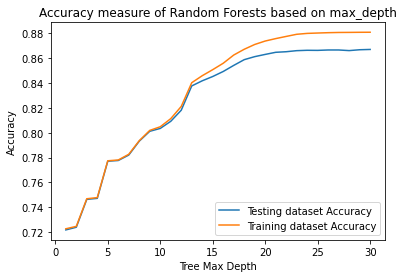

In [16]:
# Generate plot 
plt.plot(RF_max_depth, RF_test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(RF_max_depth, RF_train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend(loc = 'lower right') 
plt.title('Accuracy measure of Random Forests based on max_depth')
plt.xlabel('Tree Max Depth') 
plt.ylabel('Accuracy') 
plt.savefig('../plots/rf_accuracy_curve.png')
plt.show() 

# 3. LightGBM Classifier
### 3.1 Building the model
*First, convert all the categorical features into the category type which is used by LightGBM for processing categorical data.*

In [15]:
for c in df2.columns:
    col_type = df2[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df2[c] = df2[c].astype('category')

df2.dtypes

age                        float64
sex                       category
province                  category
country                   category
latitude_x                 float64
longitude_x                float64
date_confirmation            int64
additional_information       int64
source                       int64
outcome                   category
key                       category
latitude_y                 float64
longitude_y                float64
confirmed_sum              float64
death_sum                  float64
recovered_sum              float64
incidence_rate_avg         float64
active_sum                 float64
Case-Fatality_Ratio        float64
dtype: object

*Split the dataframe into the training data and validation data after separating the outcomes column from the rest of the dataset.*

In [16]:
y = df2['outcome']
X = df2.drop(['outcome'], axis=1)
#X_train,        X_test,         y_train,       y_test          = train_test_split(X, y, test_size = 0.2, random_state = 0)
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.20, random_state=11)
#training_data.head(5)

*Create and fit the LightGBM Classifier and save it as a pickle file.*

In [17]:
# Fit the model on the training dataset
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves = 100)# ,n_estimators = 200) #Chose 200 as n_estimators after looking at the accuracy curve 
fit_params={'feature_name': 'auto', 'categorical_feature': 'auto'}
lgbm_model.fit(training_data, training_truth, **fit_params)
# save the trained model to disk
pickle.dump(lgbm_model, open('../models/lgbm_classifier.pkl', 'wb'))


*Then, load the model from the pickle file and find the predictions on the training and validation data from the model.*

In [18]:
# load the model from disk
lgbm_model = pickle.load(open('../models/lgbm_classifier.pkl', 'rb'))
# predict on the training data
training_prediction = lgbm_model.predict(training_data)
#predict on the validation data
validation_prediction = lgbm_model.predict(validation_data)

### 3.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [19]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions:\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

LightGBM Model Predictions:

TRAINING
Accuracy score: 0.87861
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.93      0.20      0.33      3586
   hospitalized       0.80      0.89      0.84    100092
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.80      0.70      0.75     70494

       accuracy                           0.88    294100
      macro avg       0.88      0.70      0.73    294100
   weighted avg       0.88      0.88      0.87    294100


VALIDATION
Accuracy score: 0.87062
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.66      0.11      0.18       913
   hospitalized       0.79      0.88      0.83     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.78      0.68      0.73     17643

       accuracy                           0.87     73526
      macro avg       0.80      0.67      0.68   

*Also created a confusion matrix to provide a good insight to the predictions.*

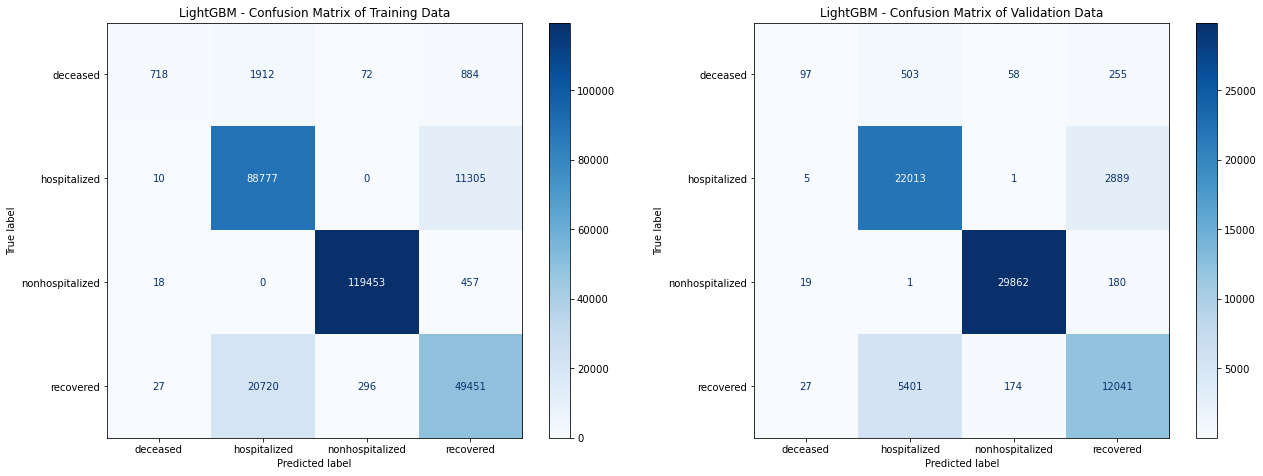

In [20]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(lgbm_model, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('LightGBM - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(lgbm_model, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('LightGBM - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/lgbm_cm.png', bbox_inches='tight', pad_inches=0.3)

### 3.3 Detecting Overfitting
*Plotting the Accuracy measure on a range of the "num_leaves" parameter to detect if the classifier is overfitting.*

In [37]:

leaves = [20,40,60,80,100,120,160,200,240,300]
train_accuracy = np.empty(len(leaves)) 
test_accuracy = np.empty(len(leaves)) 
  
# Loop over K values 
for index, value in enumerate(leaves): 
    lgbm_model = lgb.LGBMClassifier(num_leaves=value)
    lgbm_model.fit(training_data, training_truth, **fit_params)

    training_prediction = lgbm_model.predict(training_data)
    validation_prediction = lgbm_model.predict(validation_data)
    train_accuracy[index] = metrics.accuracy_score(training_prediction, training_truth)
    test_accuracy[index] = metrics.accuracy_score(validation_prediction, validation_truth)

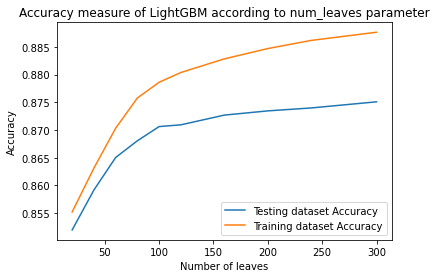

In [38]:
# Generate plot 
plt.plot(leaves, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(leaves, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.title('Accuracy measure of LightGBM according to num_leaves parameter')
plt.xlabel('Number of leaves') 
plt.ylabel('Accuracy') 
plt.savefig('../plots/lgbm_accuracy_curve.png')
plt.show() 